In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore

In [2]:
def ts_from_csv(csv_path, resampling = "h"):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    df.set_index('date_time', inplace=True)
    df.drop(columns=['date', 'time'], inplace=True)

    new_df = df.resample(resampling).sum().fillna(0)
    new_df['count'] = df.resample('H')[df.columns[0]].count().fillna(0) 
    # for col in df.columns:
    #     df[col] = np.where(zscore(df[col]) > 3, df[col].median(), df[col])

    return new_df

In [3]:
def dest_plot(df, collumn):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df, x=collumn, label=collumn)
    plt.title('Distribution density')
    plt.legend()
    plt.show()
    

In [10]:
def plot_eda(df: pd.DataFrame, target ):
    
    prefix= target.split("_")[0] + "_"
    columns = df.columns
    has_time = (df.index.hour > 0).any() or (df.index.minute > 0).any()
    mode = "hour" if has_time else "day"
   
    print(df.describe())
    
    for col in columns:
        df[col] = np.where(zscore(df[col]) > 3, df[col].median(), df[col])
    
    print(df.describe()) 

    result = adfuller(df[target])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Критический уровень %s: %.3f' % (key, value))
     # Проверка на пропущенные значения (в данном случае они будут 0)
    print(f"Пропущенные значения:\n{(df == 0).sum()}")

    # Создаем столбцы для дня недели и monthа
    df['dayofweek'] = df.index.dayofweek
    # df_resampled['week'] = df_resampled.index.week
    df['month'] = df.index.month
    df['hour'] = df.index.hour

    lags = 24*3 if has_time else 30
    plt.figure(figsize=(10, 6))
    plot_acf(df[target], lags=lags)
    plt.title(f'ACF {prefix}{mode} ')
    plt.show()

    # Автокорреляция по дням
    plt.figure(figsize=(10, 6))
    plot_pacf(df[target], lags=lags)
    plt.title(f'PACF {prefix}{mode} ')
    plt.show()
  
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='month', y=target, data=df)
    plt.title(prefix+mode)
    plt.xlabel('month')
    plt.ylabel(target)
    plt.xticks(range(12), ['Yan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='dayofweek', y=target, data=df)
    plt.title(prefix+mode)
    plt.xlabel('dayofweek')
    plt.ylabel(target)
    plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()

    if mode == 'hour':

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='hour', y=target, data=df)
        plt.title(prefix+mode)
        plt.xlabel('hour')
        plt.ylabel(target)
        plt.show()

    # Проверка мультиколлинеарности
    corr_matrix = df[columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Corr matrix for {prefix}{mode}')
    plt.show()


    # Декомпозиция временного ряда с помощью STL
    seasonal = 31 if mode == 'day' else 25*7
    print(seasonal)
    stl = STL(df[target], seasonal= seasonal)
    result = stl.fit()
    result.plot()
    plt.show()
    


In [36]:
df

,incoming_lines,incoming_brutto,incoming_volume,count
date_time,,,,
2023-01-05 08:00:00,0.004375,0.002825,0.001430,6
2023-01-05 09:00:00,0.019249,0.008062,0.004661,5
2023-01-05 10:00:00,0.016999,0.016412,0.004641,6
2023-01-05 11:00:00,0.029873,0.030261,0.028131,15
2023-01-05 12:00:00,0.029936,0.015361,0.008804,12
...,...,...,...,...
2024-04-12 12:00:00,0.150991,0.140039,0.034552,35
2024-04-12 13:00:00,0.094432,0.113761,0.040702,35
2024-04-12 14:00:00,0.075120,0.153100,0.042372,34


       outgoing_lines  outgoing_brutto  outgoing_volume       count
count      464.000000       464.000000       464.000000  463.000000
mean     26677.879310       237.811921      1799.066139    4.157667
std       6027.949942        49.416112       397.004365    4.805185
min          0.000000         0.000000         0.000000    0.000000
25%      23202.250000       217.099993      1654.039226    0.000000
50%      27055.500000       241.688303      1838.004957    3.000000
75%      30557.250000       268.943614      2041.900255    6.000000
max      42440.000000       351.355639      4287.868967   37.000000
       outgoing_lines  outgoing_brutto  outgoing_volume       count
count      464.000000       464.000000       464.000000  463.000000
mean     26677.879310       237.811921      1793.786260    4.157667
std       6027.949942        49.416112       379.749301    4.805185
min          0.000000         0.000000         0.000000    0.000000
25%      23202.250000       217.099993      1654

/var/folders/n5/300zfcyd01129kh0yhdwqc5r0000gn/T/ipykernel_37118/414319848.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_df['count'] = df.resample('H')[df.columns[0]].count().fillna(0)


<Figure size 1000x600 with 0 Axes>

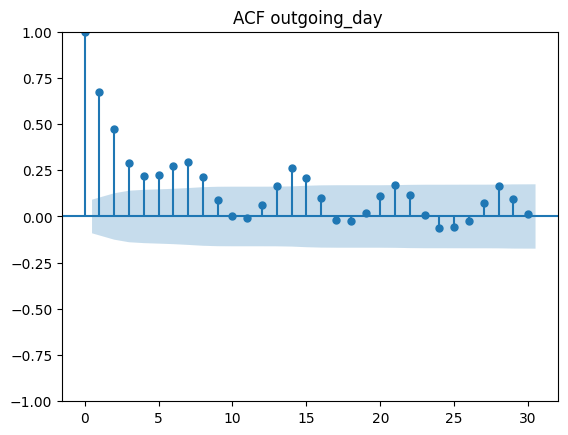

<Figure size 1000x600 with 0 Axes>

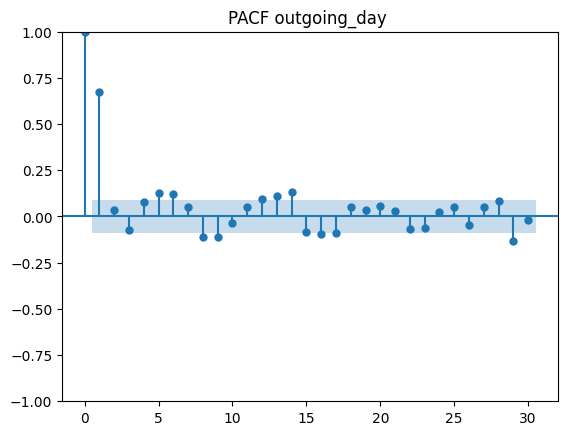

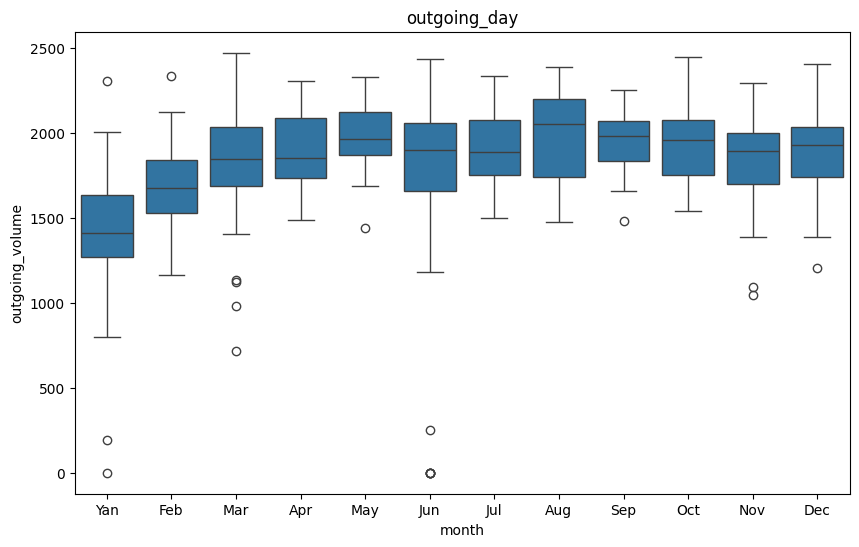

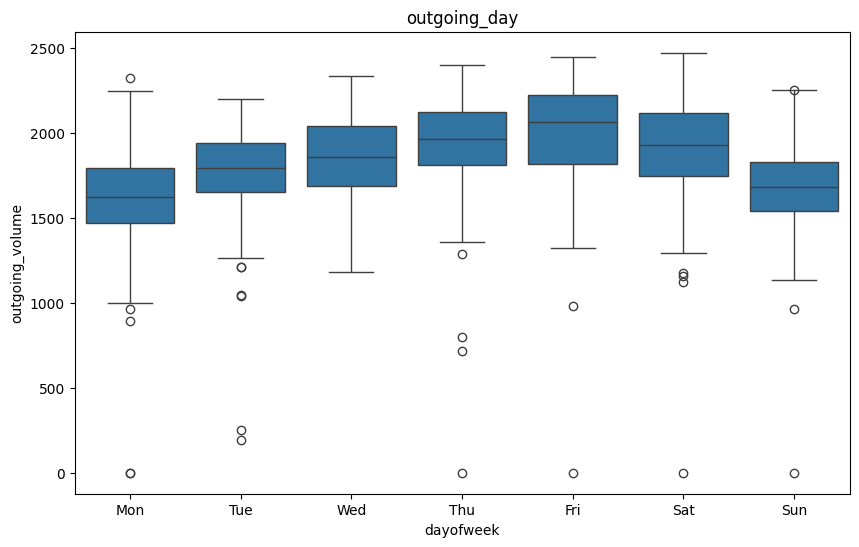

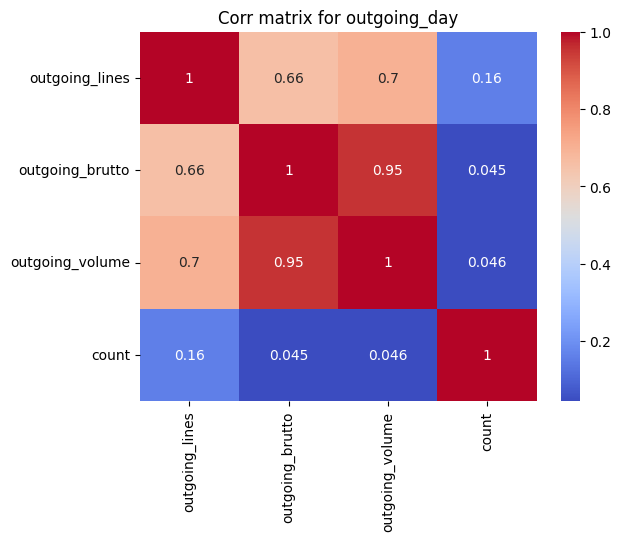

31


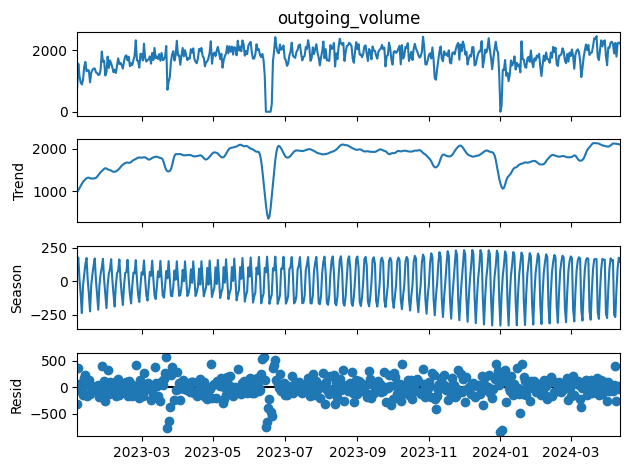

In [12]:
df = ts_from_csv("outcoming.csv", resampling="d")
df["outgoing_brutto"] /= 10**3
df["outgoing_volume"] /= 10**6
target="outgoing_volume"
plot_eda(df, target=target)

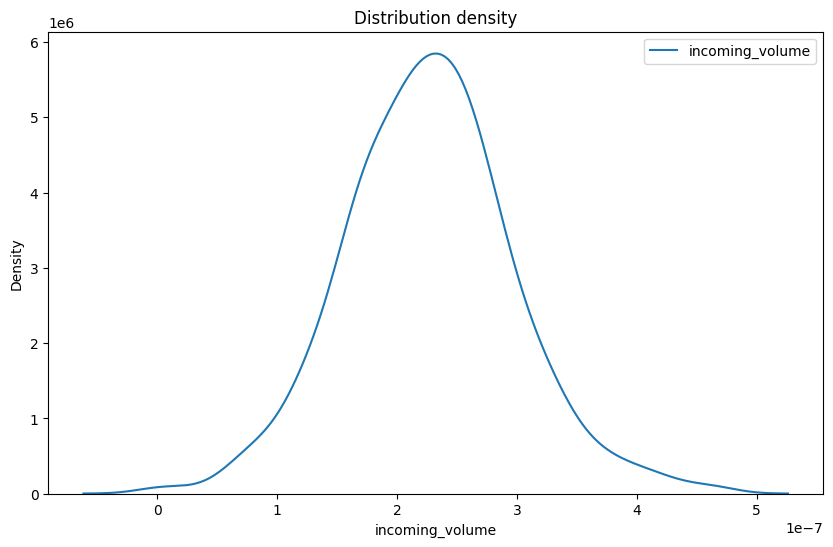

In [46]:
dest_plot(df, target)